In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
import math
from typing import List, Tuple, Union, Optional, Callable
import copy
import warnings
import matplotlib.pyplot as plt

from collab2.foraging.toolkit import dataObject, filter_by_distance


from collab2.foraging.toolkit import (
    _add_velocity,
    _generic_velocity_predictor,
    _velocity_predictor_contribution,
    animate_predictors,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

# generate data in a unit disk
theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

# # add nan values
# nan_ind = np.random.randint(0, num_frames * num_foragers, size=n_nans)
# foragersDF.loc[nan_ind, ["x", "y"]] = np.nan

# # remove values for certain time points
# drop_ind = np.random.randint(0, num_frames * num_foragers, size=n_missing)
# foragersDF = foragersDF.drop(drop_ind)

# scaling and subsampling
foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size, frames=num_frames)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

In [49]:
def piecewise_proximity_function(distance: Union[float,np.ndarray], getting_worse: float = 1.5, optimal: float =4, proximity_decay: float =1):

    cond1 = distance <= getting_worse
    cond2 = (distance > getting_worse) & (distance <= getting_worse + 1.5 * (optimal - getting_worse))

    result = np.where(
            cond1,
            np.sin(np.pi / (2 * getting_worse) * (distance + 3 * getting_worse)),
            np.where(
                cond2,
                np.sin(np.pi / (2 * (optimal - getting_worse)) * (distance - getting_worse)),
                np.sin(np.pi / (2 * (optimal - getting_worse)) * (1.5 * (optimal - getting_worse)))
                * np.exp(-proximity_decay * (distance - optimal - 0.5 * (optimal - getting_worse)))
            )
        )
    
    return result


0.3090169943749474


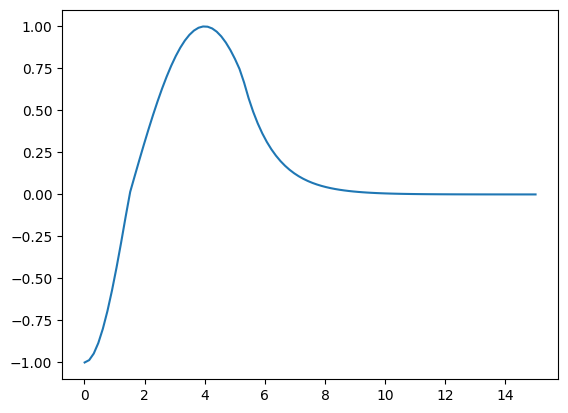

In [50]:
print(piecewise_proximity_function(2))

distance = np.linspace(0.01, 15, 100)

proximity = piecewise_proximity_function(distance)

plt.plot(distance, proximity)
plt.show()

In [6]:
distance_lj = np.linspace(4.01, 40, 100)

s = 3
n = 4
m = 2

def negative_lj(r, s_n, s_m, n, m):
    return -(s / (r+  10e-6)) ** n + (s / (r+ 10e-6)) ** m 

# plt.plot(distance_lj, [negative_lj(d, s_n, s_m, n, m) for d in distance])
# # add vertical line at optimal distance
# plt.axvline(x=7.7, color="red", linestyle="--")
# plt.axvline(x=7.22, color="red", linestyle="--")
# plt.axvline(x=7.22 - (7.7-7.22), color="red", linestyle="--")
# #add horizontal line at 0
# plt.axhline(y=0, color="black", linestyle="--")

# plt.ylim(-3, 1) 

# #plt.xlim(6,9)
# plt.show()

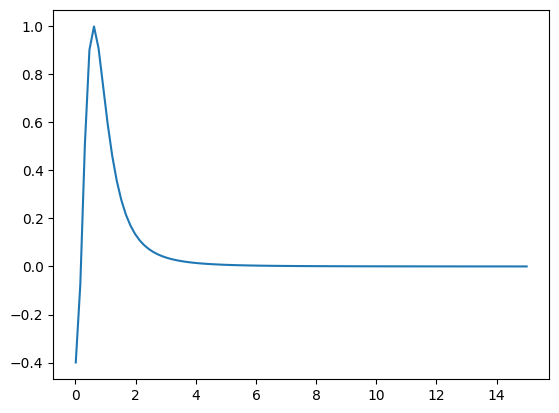

In [7]:
def softcore_potential(r, epsilon=1.0, sigma=1.0):
    return  - epsilon * (1 / ((r**2 + sigma**2) ** 6) - 2 / ((r**2 +  sigma**2) ** 3))


def softcore_potential(r, epsilon=1.0, sigma=1.0, power=3):
    return -epsilon * (1 / ((r**2 + sigma**2) ** power) - 2 / ((r**2 + sigma**2) ** (power / 2)))


plt.plot(distance, [softcore_potential(d, epsilon = 1, sigma = .8, power = 3.5) for d in distance])


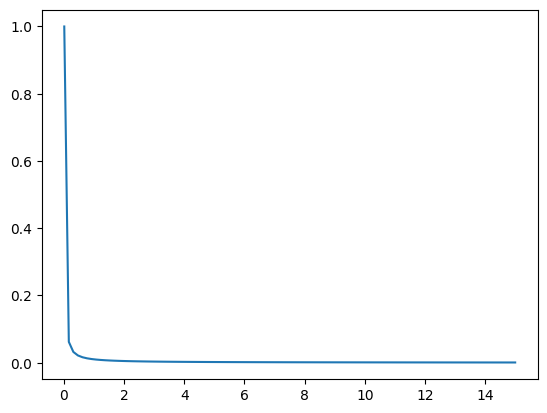

In [8]:
#yukawa coulomb potential
def yukawa_potential(r, epsilon=1.0, sigma=1.0):
    return  epsilon * np.exp(-r/sigma) / r

plt.plot(distance, [yukawa_potential(d, epsilon = .01, sigma = 10e7) for d in distance])

In [9]:
# proximity_predictor_contribution for a test case
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]

# compute the predictor contribution for a random case
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]


In [51]:
def _proximity_predictor_contribution(
    x_other: int,
    y_other: int,
    grid: pd.DataFrame,
    proximity_function: Callable,
    **proximity_function_kwargs,
) -> np.ndarray:

    distance_to_other = np.sqrt((grid["x"] - x_other) ** 2 + (grid["y"] - y_other) ** 2)
    proximity_score = proximity_function(distance_to_other, **proximity_function_kwargs)
    return proximity_score

proximity_1 = _proximity_predictor_contribution(x_other = 16, y_other = 13, 
                                  grid = local_windows[f][t],
                                  proximity_function = piecewise_proximity_function,
                                  getting_worse = 1.5,
                                  optimal = 4,
                                  proximity_decay = 1)

proximity_2 = _proximity_predictor_contribution(x_other = 8, y_other = 7,
                                    grid = local_windows[f][t],
                                    proximity_function = piecewise_proximity_function,
                                    getting_worse = 1.5,
                                    optimal = 4,
                                    proximity_decay = 1)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["proximity"] = (proximity_1 + proximity_2)


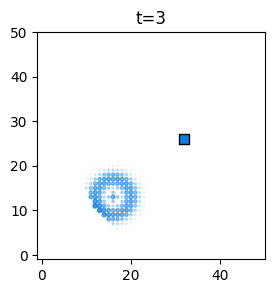

In [53]:
plot_predictor(
    foragers_object.foragers,
    test_pred,
    "proximity",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)

In [60]:
def _proximity_predictor(
    foragers: List[pd.DataFrame],
    foragersDF: pd.DataFrame,
    local_windows: List[List[pd.DataFrame]],
    predictor_name: str,
    interaction_length: float,
    interaction_constraint: Optional[
        Callable[[List[int], int, int, pd.DataFrame, Optional[dict]], List[int]]
    ] = None,
    interaction_constraint_params: Optional[dict] = None,
    proximity_function: Callable = piecewise_proximity_function,
    **proximity_function_kwargs,
) -> List[List[pd.DataFrame]]:

    num_foragers = len(foragers)
    num_frames = len(foragers[0])
    predictor = copy.deepcopy(local_windows)

    for f in range(num_foragers):
        for t in range(num_frames):
            if predictor[f][t] is not None:
                # add column for predictor_name
                predictor[f][t][predictor_name] = 0
                # find confocals within interaction length
                interaction_partners = filter_by_distance(
                    foragersDF,
                    f,
                    t,
                    interaction_length,
                    interaction_constraint,
                    interaction_constraint_params,
                )


                if len(interaction_partners) > 0:
                    for partner in interaction_partners:
                        partner_x = foragers[partner]["x"].iloc[t]
                        partner_y = foragers[partner]["y"].iloc[t]

                        predictor[f][t][predictor_name] += _proximity_predictor_contribution(
                            partner_x,
                            partner_y,
                            local_windows[f][t],
                            proximity_function,
                            **proximity_function_kwargs,
                        )

                
                #scaling to abs max (not sum, as this would lead to small numerical values)
                sum_abs_over_grid = predictor[f][t][predictor_name].abs().max() #sum()
                if sum_abs_over_grid > 0:
                     predictor[f][t][predictor_name] = (
                         predictor[f][t][predictor_name] / sum_abs_over_grid
                     )

    return predictor


original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)
new frame-rate =  2.02


/home/rafal/s78projects/collaborative-intelligence/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(


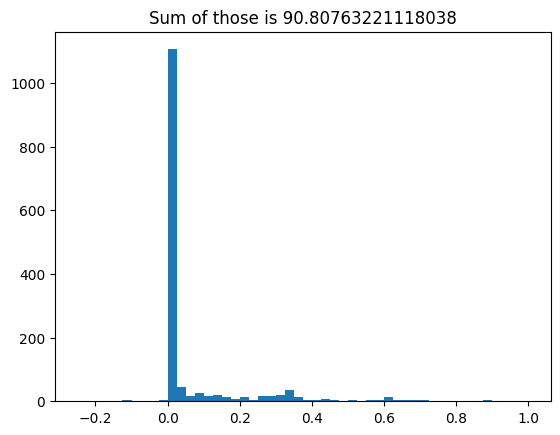

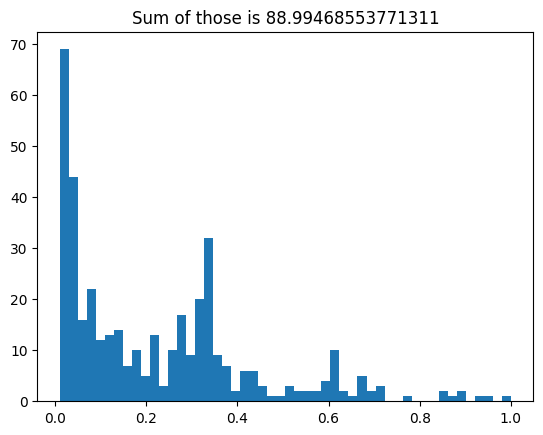

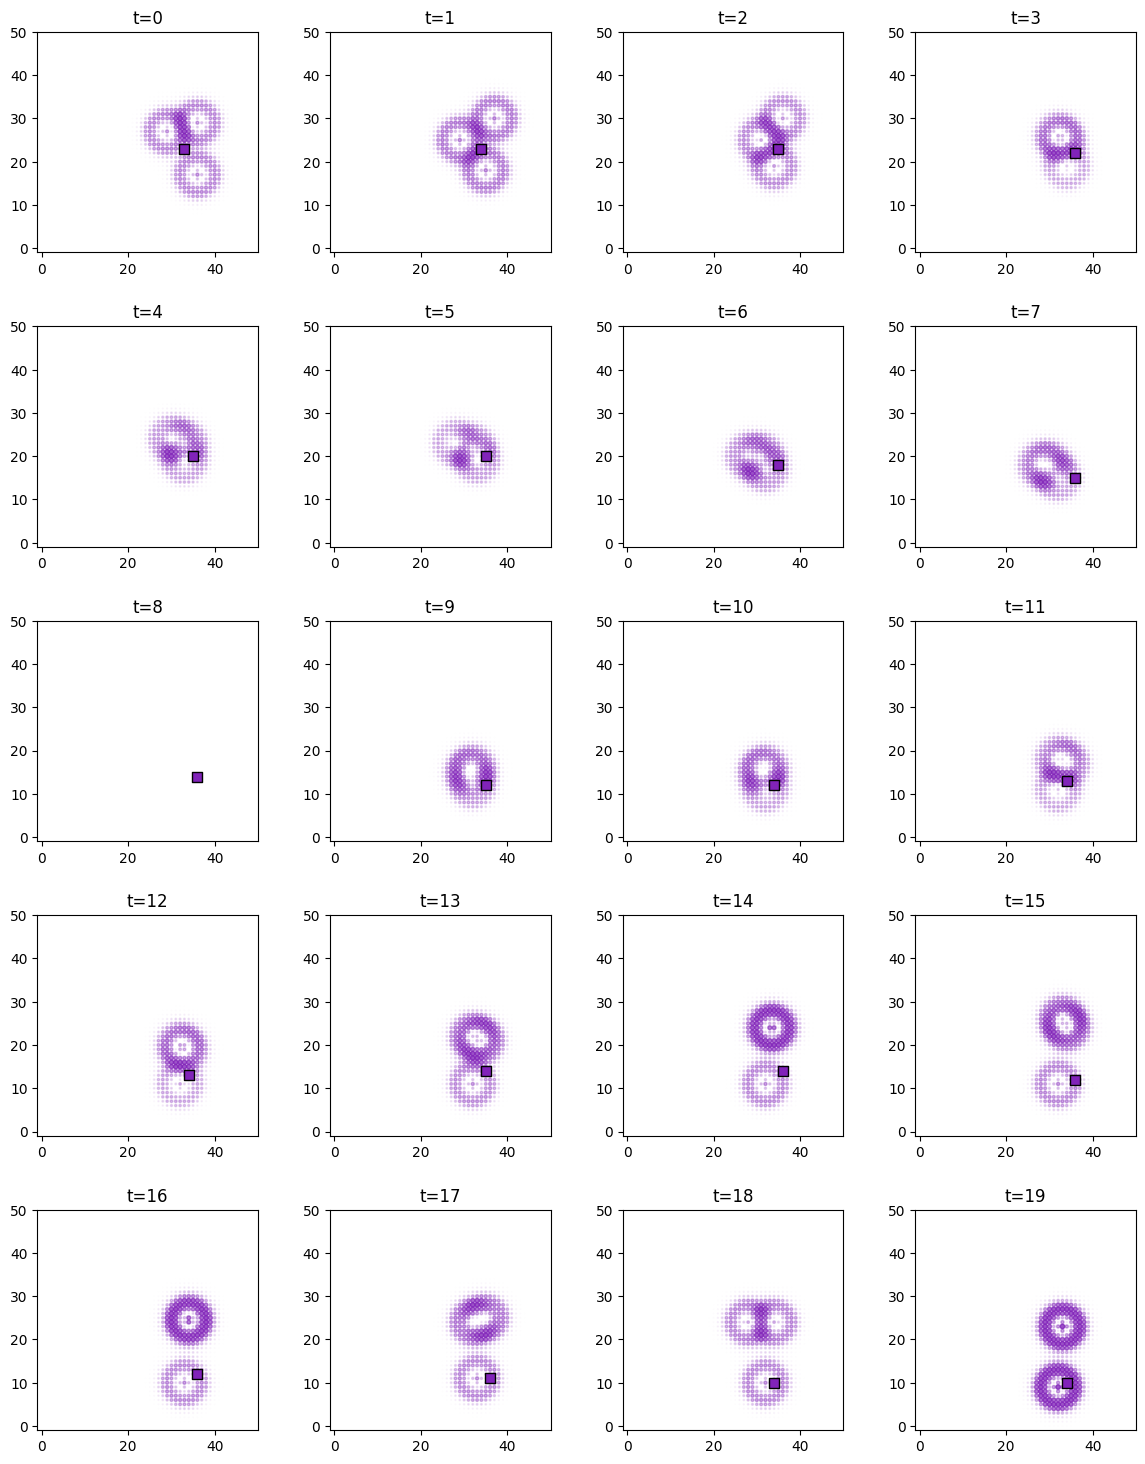

In [64]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

ppr = _proximity_predictor(
    foragers_object.foragers,
    foragers_object.foragersDF,
    local_windows,
    predictor_name="pred",
    interaction_length=grid_size / 3,
    interaction_constraint=None,
    interaction_constraint_params=None,
    proximity_function=piecewise_proximity_function,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
)

# ppr[0][0]["pred"] take non-zero

ppr_non_null = ppr[0][0]["pred"][ppr[0][0]["pred"] > 0.01]

plt.hist(ppr[0][0]["pred"], bins = 50)
plt.title(f"Sum of those is {ppr[0][0]['pred'].abs().sum()}")
plt.show()

plt.hist(ppr_non_null, bins = 50)
plt.title(f"Sum of those is {ppr_non_null.abs().sum()}")
plt.show()


plot_predictor(
    foragers_object.foragers,
    ppr,
    "pred",
    [1],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

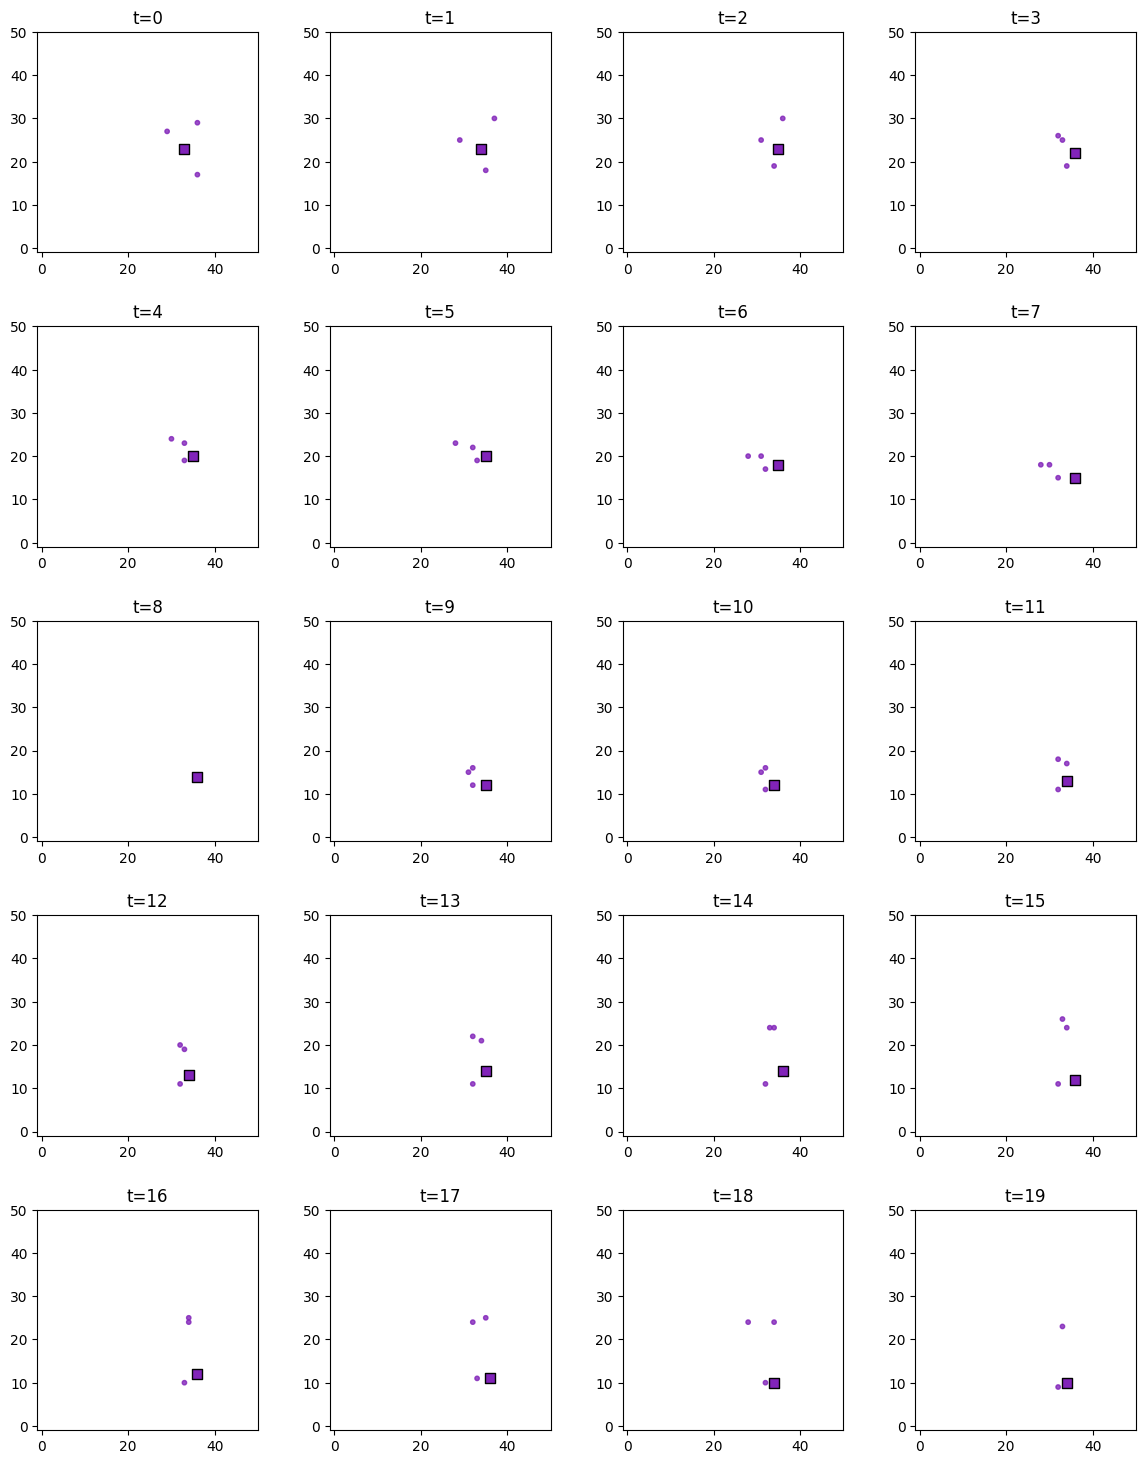

In [14]:
pprn = _proximity_predictor(
foragers_object.foragers,
foragers_object.foragersDF,
local_windows,
predictor_name="pred",
interaction_length=grid_size / 3,
interaction_constraint=None,
interaction_constraint_params=None,
proximity_function=negative_lj,
s_n=3,
s_m=3,
n=4,
m=2,
)

plot_predictor(
foragers_object.foragers,
pprn,
"pred",
[1],
range(num_frames),
grid_size,
size_multiplier=10,
random_state=99,
)

2024-08-23 14:03:14,584 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-08-23 14:03:14,617 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


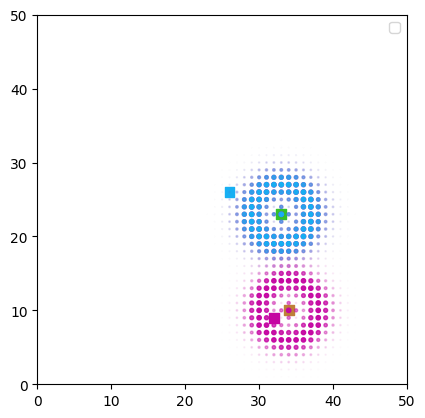

In [15]:
ani = animate_predictors(
    foragers_object.foragersDF,
    ppr,
    predictorID="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

In [39]:
# adding interaction constraint: nearest neighbor

def filter_nearest(f_ind, f, t, foragersDF, params):
    current_positions = foragersDF.loc[
        np.logical_and(foragersDF["forager"].isin(f_ind), foragersDF["time"] == t)
    ]

    x_f = foragersDF.loc[
        np.logical_and(foragersDF["forager"] == f, foragersDF["time"] == t), "x"
    ].values[0]

    y_f = foragersDF.loc[
        np.logical_and(foragersDF["forager"] == f, foragersDF["time"] == t), "y"
    ].values[0]

    distances = np.sqrt((current_positions["x"] - x_f) ** 2 + (current_positions["y"] - y_f) ** 2)

    return current_positions['forager'][distances == distances.min()].to_list()

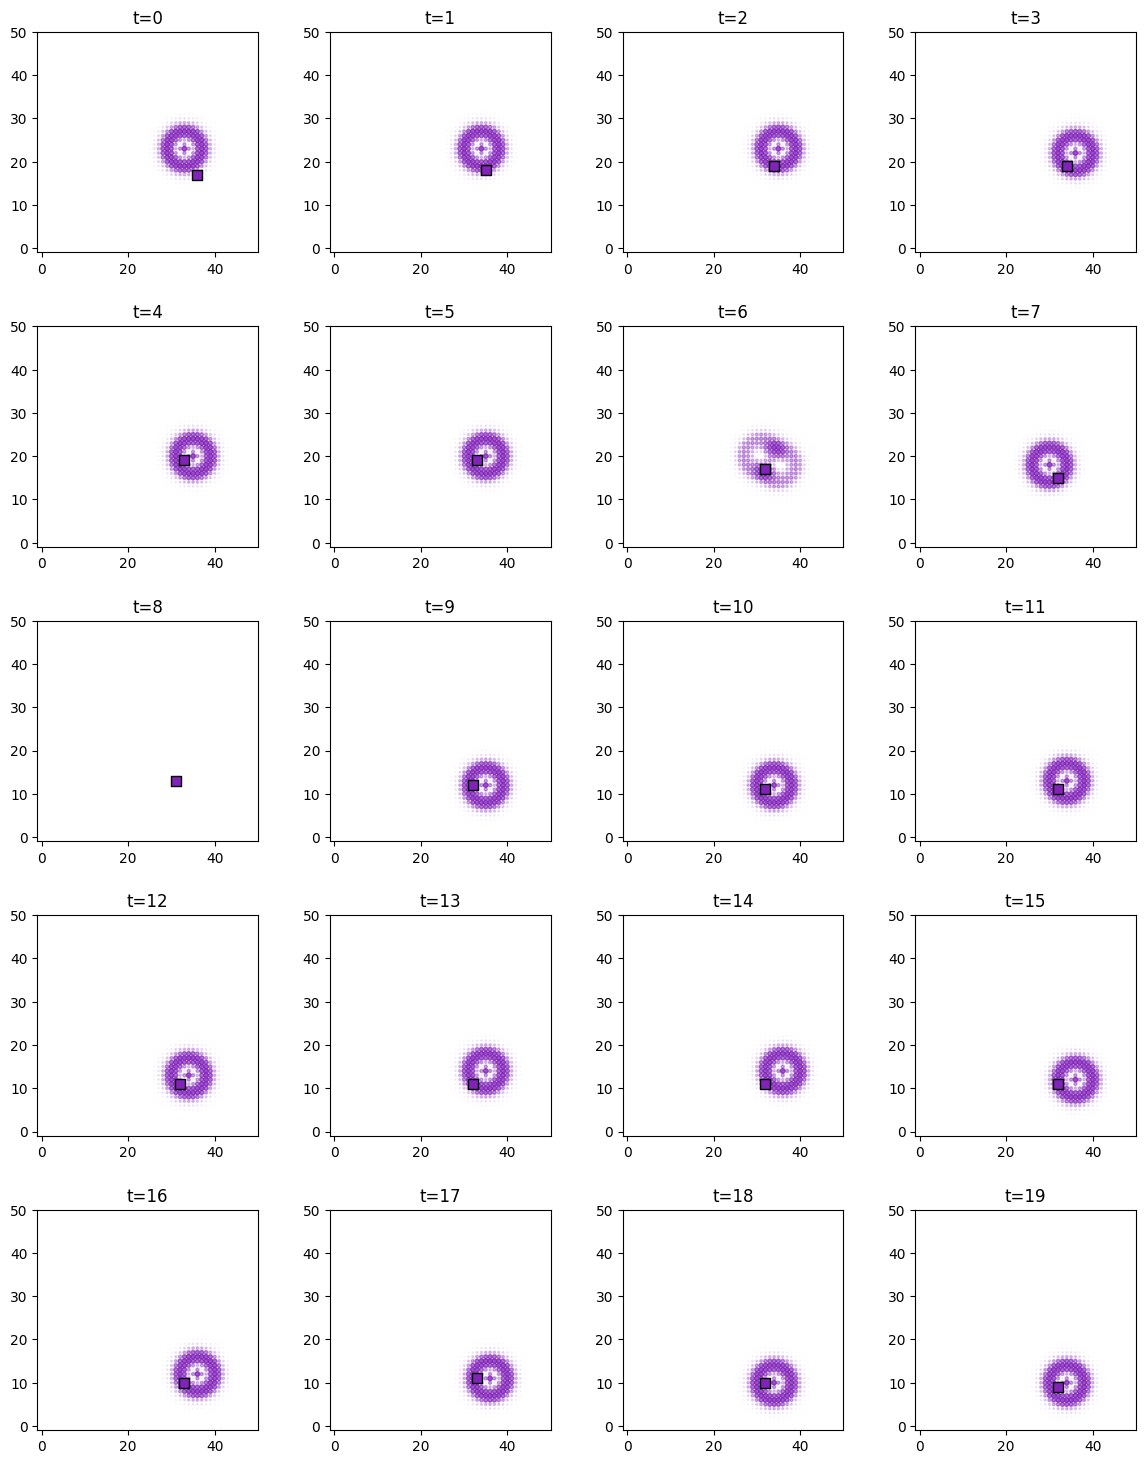

In [40]:
pred_max = _proximity_predictor(
    foragers_object.foragers,
    foragers_object.foragersDF,
    local_windows,
    predictor_name="pred",
    interaction_length=grid_size / 3,
    interaction_constraint=filter_nearest,
    interaction_constraint_params={"f_ind": [0, 1, 2, 3]},
    proximity_function=piecewise_proximity_function,
    getting_worse=1.5,
    optimal=4,
    proximity_decay=1,
)

plot_predictor(
    foragers_object.foragers,
    pred_max,
    "pred",
    [0],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

In [43]:
def generate_proximity(foragers_object: dataObject, predictor_name: str):
 
    params = foragers_object.predictor_kwargs[predictor_name]

    predictor = _proximity_predictor(
        foragers_object.foragers,
        foragers_object.foragersDF,
        foragers_object.local_windows,
        predictor_name=predictor_name,
        **params,
    )

    return predictor

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)
new frame-rate =  2.02


/home/rafal/s78projects/collaborative-intelligence/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(
2024-08-23 14:54:46,199 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-08-23 14:54:46,228 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


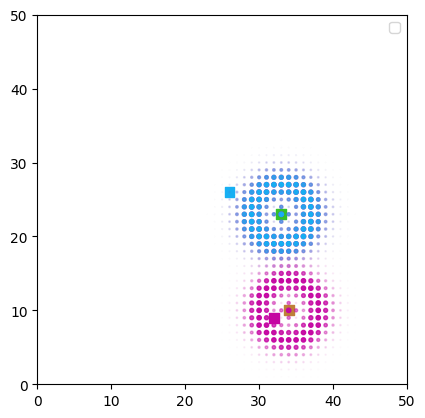

In [46]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# generate local windows and add to object
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}
foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

predictor_kwargs = {
    "pred": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": None,
        "proximity_function": piecewise_proximity_function,
        "getting_worse": 1.5,
        "optimal": 4,
        "proximity_decay": 1,
    }
}


foragers_object.predictor_kwargs = predictor_kwargs

proximity = generate_proximity(foragers_object, "pred")


ani = animate_predictors(
    foragers_object.foragersDF,
    proximity,
    predictorID="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())